# Real Life Case Example

## Building Insight & Communicating

## Frame

The busienss objective in this loan default case is to minimize the loss given default. So we need to define a loss function for our problem.

Let us take a simple assumption that we will make 10% of the amount if we make a successful loan, but we will only recover 80% of the loan amount if it defaults 

- Successful loan = amount * 10%
- Default loan  = - amount * 80%


In [1]:
#Load the libraries
import numpy as np
import pandas as pd
%matplotlib inline
from plotnine import *
import ipywidgets as widgets
from ipywidgets import interact, interactive,fixed, interact_manual, IntSlider

/Users/amitkaps/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Acquire

In [2]:
#Load the training dataset
df = pd.read_csv("../data/loan_unbalanced.csv")

## Refine

In [3]:
df.isnull().sum()

default        0
amount         0
grade          0
years        809
ownership      0
income         0
age            0
dtype: int64

In [4]:
df.years = df.years.fillna(np.mean(df.years))

# Explore

In [5]:
pd.crosstab(df.default, df.grade)

grade,A,B,C,D,E,F,G
default,,,,,,,
0,9084,8344,4904,2651,692,155,35
1,565,985,844,580,176,56,21


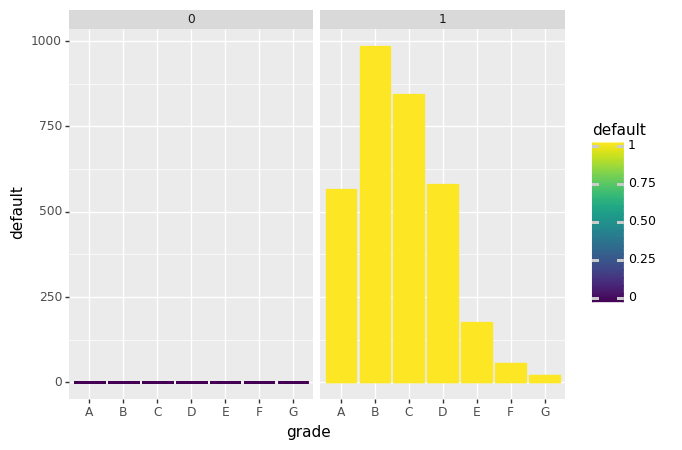

<ggplot: (299238776)>

In [6]:
ggplot(df) + aes('grade', 'default', color='default') + geom_col() + facet_wrap('default')

# Transform

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y )

In [10]:
df_train = df[df.index.isin(X_train.index)]
df_test = df[df.index.isin(X_test.index)]

In [11]:
df_test.head()

,default,amount,grade,years,ownership,income,age
6,1,9000,C,0.0,RENT,30000.00,22
11,0,3600,A,13.0,MORTGAGE,110000.00,27
13,0,9200,A,6.0,RENT,77385.19,24
16,0,10000,B,5.0,RENT,50000.00,22
21,0,8500,B,0.0,RENT,25000.00,24


In [12]:
X_test.head()

,amount,grade,years,ownership,income,age
28314,9600,C,4.0,RENT,78000.0,27
5408,5000,C,3.0,RENT,32000.0,23
27277,1200,A,0.0,OTHER,40000.0,27
17595,10000,C,7.0,RENT,43080.0,27
13934,5000,A,21.0,MORTGAGE,72000.0,22


## Model

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
from sklearn.externals import joblib

# read the encoders and the model
grade_encoder = joblib.load("../notebooks/le_grade.pkl")
ownership_encoder = joblib.load("../notebooks/le_ownership.pkl")


In [15]:
def train_model(X,y):
    """Trains a random forest model based on the training data
    """
    X_copy = X.copy()
    
     # encoders the features 
    X_copy['grade_encoded'] = grade_encoder.transform(X_copy.grade)
    X_copy['ownership_encoded'] = ownership_encoder.transform(X_copy.ownership)
    X_t = X_copy[['amount', 'grade_encoded', 'years', 'ownership_encoded', 'income', 'age']]
    
    # Train the model
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 100, class_weight= {0: 1, 1: 1000})
    clf = clf.fit(X_t,y)
    
    return clf
    

In [16]:
model = train_model(X_train, y_train)

In [17]:
clf = train_model(X_train, y_train)

In [18]:
def predict_test(X, y, model):
    """Returns the probablity of default for the dataframe based on a model.
    """
    
    X_copy = X.copy()
    df_copy = df.copy()
    
    
    # encoders for 
    X_copy['grade_encoded'] = grade_encoder.transform(X_copy.grade)
    X_copy['ownership_encoded'] = ownership_encoder.transform(X_copy.ownership)
    
    # important to pass the features in the same order as we built the model
    X_t = X_copy[['amount', 'grade_encoded', 'years', 'ownership_encoded', 'income', 'age']]
    
    # probablity for defaulting
    p1 = model.predict_proba(X_t)[:, 1]
    pred_df = pd.DataFrame({"default": np.array(y), "amount": np.array(X.amount), "proba": p1})
    
    # Binning the probability & counts in each bin
    pred_df['proba_bin'] = np.round(pred_df.proba*100, decimals=0)/100
    pred_df['proba_bin_count'] = (pred_df.sort_values(by = ["proba_bin", "default"])
                                        .groupby(['proba_bin'])
                                        .cumcount() + 1)
    
    return pred_df
    

In [19]:
test_out = predict_test(X_test, y_test, clf)

In [20]:
test_out.head()

,amount,default,proba,proba_bin,proba_bin_count
0,9600,0,0.33,0.33,1
1,5000,0,0.07,0.07,1
2,1200,0,0.07,0.07,2
3,10000,0,0.15,0.15,1
4,5000,0,0.03,0.03,1


In [21]:
def get_test_prediction(df, threshold): 
    ''' Code the accuracy based on threshold
    '''
    
    df1 = df.copy()
    
    ## Get class prediction
    df1['pred'] = 0
    df1.loc[df1.proba_bin>=threshold, 'pred'] = 1
    
    ## Make input-ouput code
    df1['pred_class'] = "00"
    df1.loc[(df1.default == 0) & (df1.pred == 1), 'pred_class'] = "01"
    df1.loc[(df1.default == 1) & (df1.pred == 0), 'pred_class'] = "10"
    df1.loc[(df1.default == 1) & (df1.pred == 1), 'pred_class'] = "11"

    return df1

In [22]:
get_test_prediction(test_out, 0.4).head()

,amount,default,proba,proba_bin,proba_bin_count,pred,pred_class
0,9600,0,0.33,0.33,1,0,00
1,5000,0,0.07,0.07,1,0,00
2,1200,0,0.07,0.07,2,0,00
3,10000,0,0.15,0.15,1,0,00
4,5000,0,0.03,0.03,1,0,00


In [27]:
def plot_test_prediction(df, threshold):
    df1 = get_test_prediction(df,threshold)
    g = (ggplot(df1) + 
         aes('proba_bin', 'proba_bin_count', fill='pred_class') + 
         geom_tile(color = "white") + scale_fill_manual(['#ca0020','#f4a582','#92c5de','#0571b0']) +
         xlab("threshold") + ylab("count") )
    print(g)

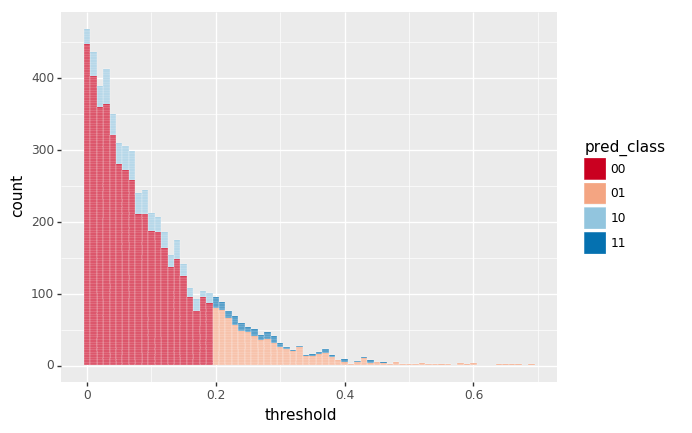

<ggplot: (-9223372036549969390)>


In [28]:
plot_test_prediction(test_out, 0.2)

In [29]:
threshold_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.2)

In [30]:
interactive(plot_test_prediction, df=fixed(test_out), threshold = threshold_widget)

A Jupyter Widget

## Insight

Lets calculate the loss for the calculation

In [31]:
def loss(df, threshold):
    df1 = get_test_prediction(df, threshold)
    success = df1.loc[(df1.pred == 0) & (df1.default == 0), 'amount' ].sum() * 0.1
    failure = df1.loc[(df1.pred == 0) & (df1.default == 1), 'amount' ].sum() * -0.8
    loss = success + failure
        
    return loss    

In [32]:
loss(test_out, 0.4)

129432.5

In [35]:
def plot_loss(df):
    thresh = np.arange(0,1,0.01)
    loss_calc = [loss(test_out, x) for x in thresh]
    df_ = pd.DataFrame({"threshold": thresh, "loss": loss_calc})        
    return df_

In [36]:
lossdf = plot_loss(test_out)

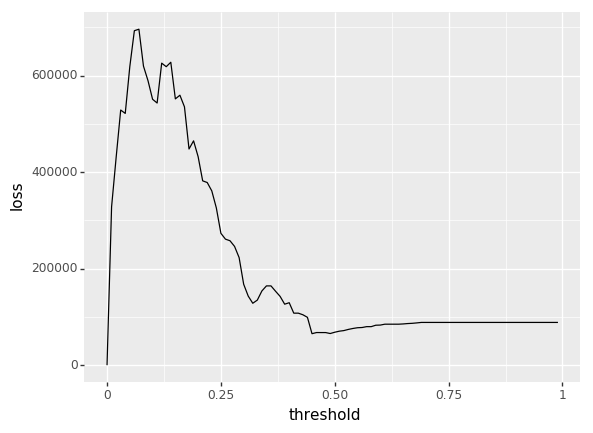

<ggplot: (300742078)>

In [37]:
ggplot(lossdf) + aes('threshold', 'loss') + geom_line()